In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (classification_report, roc_auc_score, mean_absolute_error, 
                            mean_squared_error, r2_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 ML-PROBLEM DEFINITION:")
print("1. KLASSIFICERING: Är en transfer gratis (fee_cleaned = 0) eller avgiftsbelagd?")
print("2. REGRESSION: Förutspå transfersumman (fee_cleaned) för avgiftsbelagda transfers")
print("3. VIKTIGT: Undvika data leakage genom att endast använda features som är kända FÖRE transfer-status")

🎯 ML-PROBLEM DEFINITION:
1. KLASSIFICERING: Är en transfer gratis (fee_cleaned = 0) eller avgiftsbelagd?
2. REGRESSION: Förutspå transfersumman (fee_cleaned) för avgiftsbelagda transfers
3. VIKTIGT: Undvika data leakage genom att endast använda features som är kända FÖRE transfer-status


In [51]:
df = pd.read_csv('data/all_leagues_combined.csv')

print("DATASET OVERVIEW:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


print("\n DATA QUALITY CHECK:")
print(df.info())
print(f"\nSaknade värden per kolumn:\n{df.isnull().sum()}")


print("\n⚖️ ETISKA ÖVERVÄGANDEN:")
print("- Modellen kan förstärka bias mot vissa ligor/länder")
print("- Historiska mönster kan undervärdera vissa spelartyper")
print("- Viktigt att validera på olika ligor och tidsperioder")

DATASET OVERVIEW:
Shape: (177412, 14)
Columns: ['club_name', 'player_name', 'age', 'position', 'club_involved_name', 'fee', 'transfer_movement', 'transfer_period', 'fee_cleaned', 'league_name', 'year', 'season', 'country', 'source_file']
Memory usage: 115.5 MB

 DATA QUALITY CHECK:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177412 entries, 0 to 177411
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   club_name           177412 non-null  object 
 1   player_name         177412 non-null  object 
 2   age                 177342 non-null  float64
 3   position            177412 non-null  object 
 4   club_involved_name  177412 non-null  object 
 5   fee                 177299 non-null  object 
 6   transfer_movement   177412 non-null  object 
 7   transfer_period     177412 non-null  object 
 8   fee_cleaned         66564 non-null   float64
 9   league_name         177412 non-null  object 
 10  y

In [52]:
df_clean = df.copy()
print(f"Original: {df_clean.shape}")

# Ta bort duplicerade transfers baserat på spelare, klubb och datum
df_clean = df_clean.drop_duplicates(subset=['player_name', 'club_name', 'year', 'fee_cleaned'])
print(f"Efter duplicatborttagning: {df_clean.shape}")

# Ta bort transfers utan giltiga klubbnamn
df_clean = df_clean.dropna(subset=['club_name', 'club_involved_name'])
print(f"Efter klubbnamnrensning: {df_clean.shape}")

# Använd den rensade datan för EDA
df_eda = df_clean.copy()

# Rensa bort extrema outliers och saknade värden
df_eda = df_eda.dropna(subset=['fee_cleaned', 'age', 'position'])
df_eda = df_eda[df_eda['fee_cleaned'] >= 0]  


print("DATAKVALITETSKONTROLL:")
print(f"Åldrar innan rensning: min={df_eda['age'].min()}, max={df_eda['age'].max()}")


df_eda = df_eda[(df_eda['age'] >= 15) & (df_eda['age'] <= 45)]

print(f"Åldrar efter rensning: min={df_eda['age'].min()}, max={df_eda['age'].max()}")
print(f"Antal transfers efter åldersfiltrering: {len(df_eda):,}")

print("\n GRUNDLÄGGANDE STATISTIK:")
print(f"Tidsperiod: {df_eda['year'].min()}-{df_eda['year'].max()}")
print(f"Antal unika spelare: {df_eda['player_name'].nunique():,}")
print(f"Antal ligor: {df_eda['league_name'].nunique()}")
print(f"Antal länder: {df_eda['country'].nunique()}")
print(f"Genomsnittlig ålder: {df_eda['age'].mean():.1f} år")
print(f"Åldersspan: {df_eda['age'].min()}-{df_eda['age'].max()} år")

Original: (177412, 14)
Efter duplicatborttagning: (151639, 14)
Efter klubbnamnrensning: (151639, 14)
DATAKVALITETSKONTROLL:
Åldrar innan rensning: min=9.0, max=2011.0
Åldrar efter rensning: min=15.0, max=45.0
Antal transfers efter åldersfiltrering: 65,847

 GRUNDLÄGGANDE STATISTIK:
Tidsperiod: 1992-2022
Antal unika spelare: 24,197
Antal ligor: 9
Antal länder: 8
Genomsnittlig ålder: 25.4 år
Åldersspan: 15.0-45.0 år


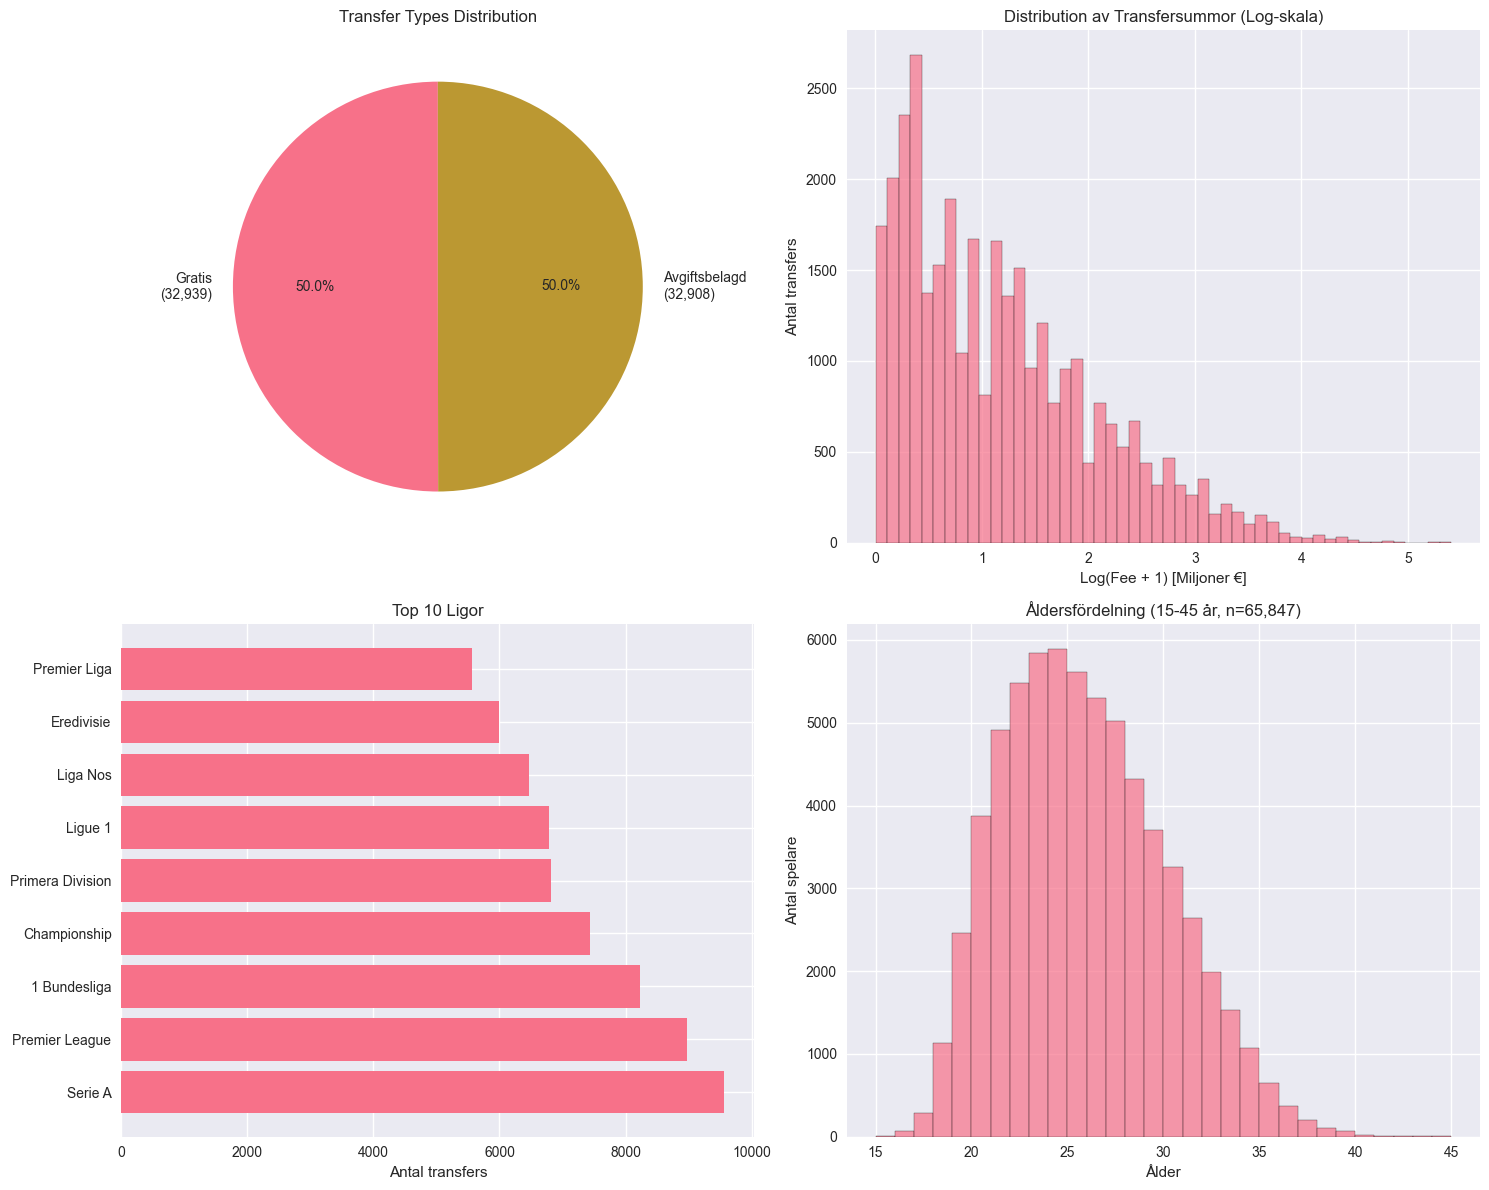


💰 TRANSFER FEE STATISTIK:
Gratis transfers: 32,939 (50.0%)
Genomsnittlig avgiftsbelagd transfer: €4.52M
Median avgiftsbelagd transfer: €1.70M
Högsta transfer: €222.0M


In [35]:
# Transfer fee distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Gratis vs Avgiftsbelagda transfers
free_transfers = (df_eda['fee_cleaned'] == 0).sum()
paid_transfers = (df_eda['fee_cleaned'] > 0).sum()

axes[0,0].pie([free_transfers, paid_transfers], 
              labels=[f'Gratis\n({free_transfers:,})', f'Avgiftsbelagd\n({paid_transfers:,})'],
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Transfer Types Distribution')

# 2. Fee distribution (log scale för paid transfers)
paid_fees = df_eda[df_eda['fee_cleaned'] > 0]['fee_cleaned']
axes[0,1].hist(np.log1p(paid_fees), bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Log(Fee + 1) [Miljoner €]')
axes[0,1].set_ylabel('Antal transfers')
axes[0,1].set_title('Distribution av Transfersummor (Log-skala)')

# 3. Top 10 ligor efter antal transfers
top_leagues = df_eda['league_name'].value_counts().head(10)
axes[1,0].barh(range(len(top_leagues)), top_leagues.values)
axes[1,0].set_yticks(range(len(top_leagues)))
axes[1,0].set_yticklabels(top_leagues.index)
axes[1,0].set_xlabel('Antal transfers')
axes[1,0].set_title('Top 10 Ligor')

# 4. Åldersfördelning (med realistiska gränser)
age_data = df_eda['age'].dropna()
# Filtrera bort orealistiska åldrar
realistic_ages = age_data[(age_data >= 15) & (age_data <= 45)]

axes[1,1].hist(realistic_ages, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Ålder')
axes[1,1].set_ylabel('Antal spelare')
axes[1,1].set_title(f'Åldersfördelning (15-45 år, n={len(realistic_ages):,})')

# Visa statistik om åldersdata
outlier_ages = age_data[(age_data < 15) | (age_data > 45)]
if len(outlier_ages) > 0:
    print(f"\n⚠️ Orealistiska åldrar hittade: {len(outlier_ages)} st")
    print(f"   Min ålder: {age_data.min()}")
    print(f"   Max ålder: {age_data.max()}")
    print(f"   Extrema värden: {sorted(outlier_ages.unique())[:10]}...")

plt.tight_layout()
plt.show()

# Statistik
print(f"\n💰 TRANSFER FEE STATISTIK:")
print(f"Gratis transfers: {free_transfers:,} ({free_transfers/len(df_eda)*100:.1f}%)")
if len(paid_fees) > 0:
    print(f"Genomsnittlig avgiftsbelagd transfer: €{paid_fees.mean():.2f}M")
    print(f"Median avgiftsbelagd transfer: €{paid_fees.median():.2f}M")
    print(f"Högsta transfer: €{paid_fees.max():.1f}M")

ANALYS: ENDAST BETALDA TRANSFERS
Antal betalda transfers: 32,908
Totalt antal transfers (exkl. lån): 65,847
Andel betalda transfers: 50.0%


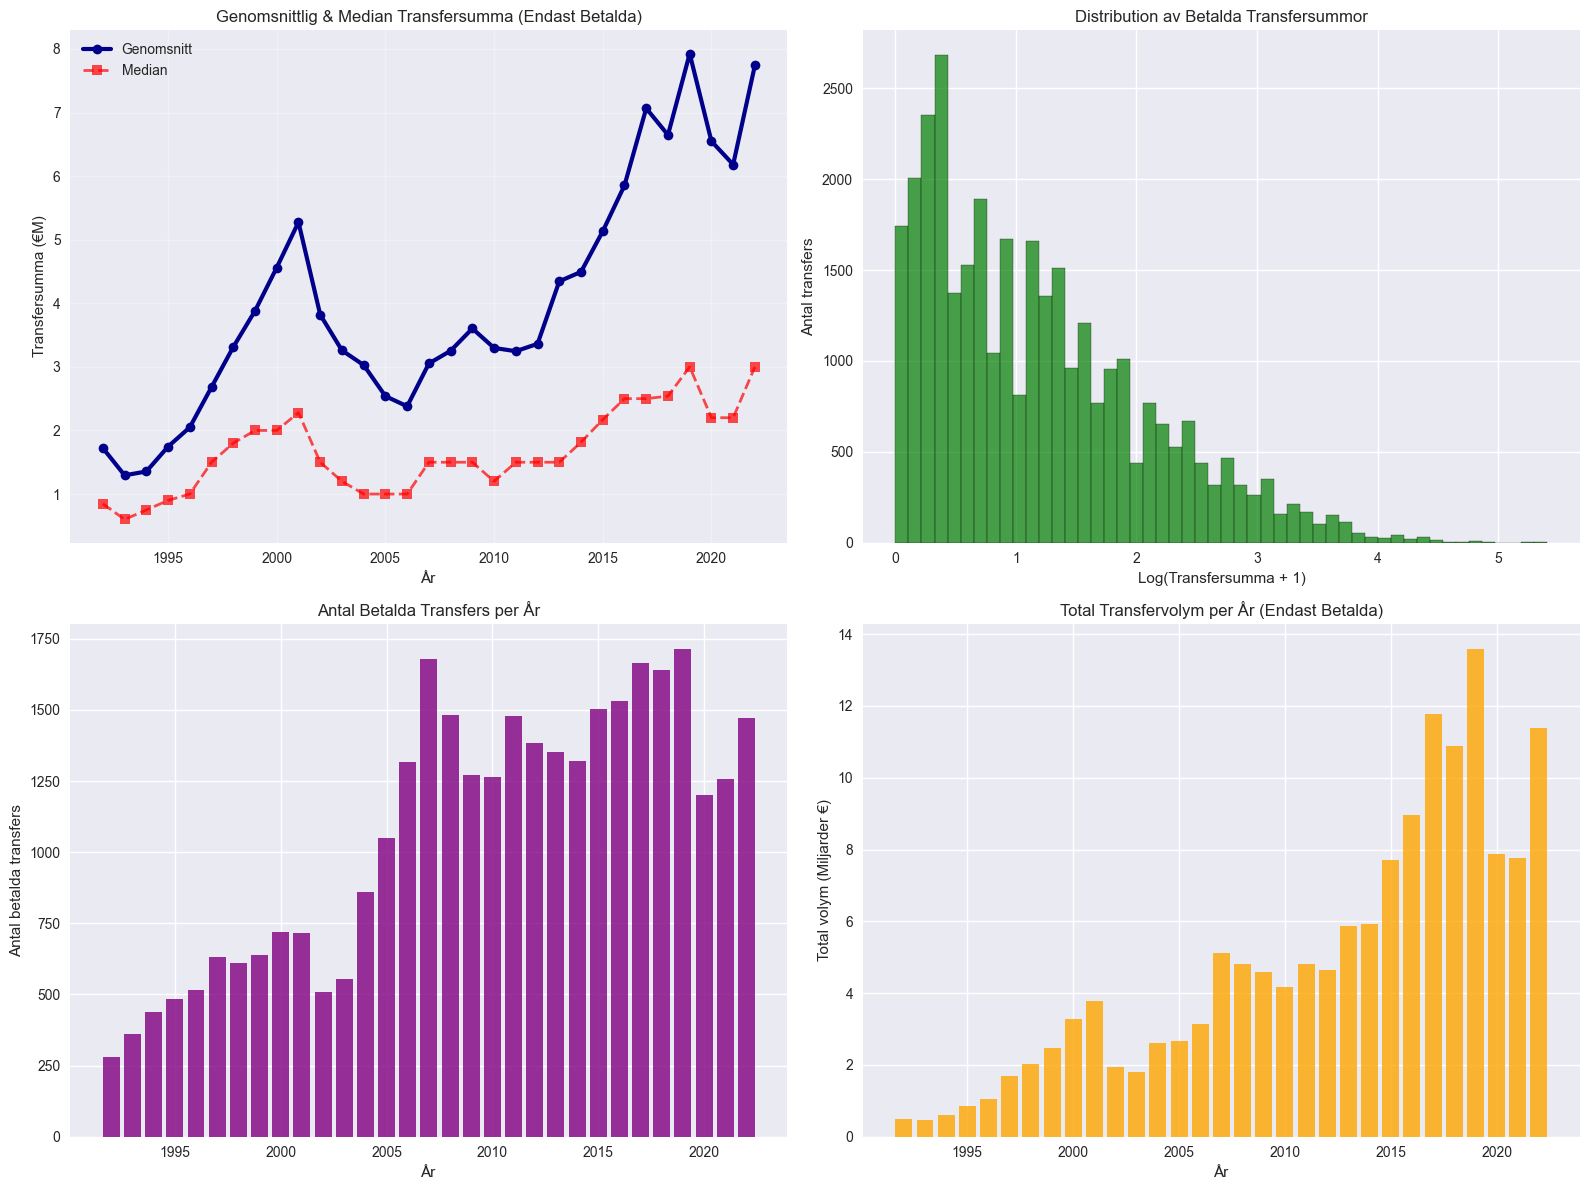


 STATISTIK FÖR BETALDA TRANSFERS:
Genomsnittlig transfersumma: €4.52M
Median transfersumma: €1.70M
Högsta transfersumma: €222.0M
Lägsta transfersumma: €0.001M
Standardavvikelse: €8.66M

 PERCENTILER FÖR BETALDA TRANSFERS:
10e percentilen: €  0.20M
25e percentilen: €  0.50M
50e percentilen: €  1.70M
75e percentilen: €  4.80M
90e percentilen: € 11.30M
95e percentilen: € 18.00M
99e percentilen: € 40.00M

 JÄMFÖRELSE MELLAN TIDSPERIODER (ENDAST BETALDA):
1990-1999 : Snitt: €  2.43M | Median: €  1.10M | Antal: 3,958 | Total: €  9637.7M
2000-2009 : Snitt: €  3.32M | Median: €  1.40M | Antal: 10,166 | Total: € 33769.1M
2010-2019 : Snitt: €  5.28M | Median: €  2.00M | Antal: 14,855 | Total: € 78373.2M
2020-2024 : Snitt: €  6.88M | Median: €  2.50M | Antal: 3,929 | Total: € 27025.1M

 GENOMSNITTLIG TRANSFERSUMMA PER LIGA (ENDAST BETALDA):
Premier League      : Snitt: €  6.90M | Antal:  5750 | Total: € 39663.0M
Primera Division    : Snitt: €  6.19M | Antal:  3698 | Total: € 22878.8M
Ligue 1    

In [36]:

print("ANALYS: ENDAST BETALDA TRANSFERS")
print("=" * 50)


paid_only = df_eda[df_eda['fee_cleaned'] > 0].copy()
print(f"Antal betalda transfers: {len(paid_only):,}")
print(f"Totalt antal transfers (exkl. lån): {len(df_eda):,}")
print(f"Andel betalda transfers: {len(paid_only)/len(df_eda)*100:.1f}%")


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


yearly_paid_stats = paid_only.groupby('year')['fee_cleaned'].agg(['mean', 'count', 'sum', 'median'])

axes[0,0].plot(yearly_paid_stats.index, yearly_paid_stats['mean'], 
               marker='o', linewidth=3, color='darkblue', label='Genomsnitt')
axes[0,0].plot(yearly_paid_stats.index, yearly_paid_stats['median'], 
               marker='s', linewidth=2, color='red', linestyle='--', alpha=0.7, label='Median')
axes[0,0].set_xlabel('År')
axes[0,0].set_ylabel('Transfersumma (€M)')
axes[0,0].set_title('Genomsnittlig & Median Transfersumma (Endast Betalda)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()


axes[0,1].hist(np.log1p(paid_only['fee_cleaned']), bins=50, alpha=0.7, 
               color='green', edgecolor='black')
axes[0,1].set_xlabel('Log(Transfersumma + 1)')
axes[0,1].set_ylabel('Antal transfers')
axes[0,1].set_title('Distribution av Betalda Transfersummor')


axes[1,0].bar(yearly_paid_stats.index, yearly_paid_stats['count'], 
              alpha=0.8, color='purple')
axes[1,0].set_xlabel('År')
axes[1,0].set_ylabel('Antal betalda transfers')
axes[1,0].set_title('Antal Betalda Transfers per År')


axes[1,1].bar(yearly_paid_stats.index, yearly_paid_stats['sum']/1000, 
              alpha=0.8, color='orange')
axes[1,1].set_xlabel('År')
axes[1,1].set_ylabel('Total volym (Miljarder €)')
axes[1,1].set_title('Total Transfervolym per År (Endast Betalda)')

plt.tight_layout()
plt.show()


print(f"\n STATISTIK FÖR BETALDA TRANSFERS:")
print(f"Genomsnittlig transfersumma: €{paid_only['fee_cleaned'].mean():.2f}M")
print(f"Median transfersumma: €{paid_only['fee_cleaned'].median():.2f}M")
print(f"Högsta transfersumma: €{paid_only['fee_cleaned'].max():.1f}M")
print(f"Lägsta transfersumma: €{paid_only['fee_cleaned'].min():.3f}M")
print(f"Standardavvikelse: €{paid_only['fee_cleaned'].std():.2f}M")


percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\n PERCENTILER FÖR BETALDA TRANSFERS:")
for p in percentiles:
    value = np.percentile(paid_only['fee_cleaned'], p)
    print(f"{p:2d}e percentilen: €{value:6.2f}M")


print(f"\n JÄMFÖRELSE MELLAN TIDSPERIODER (ENDAST BETALDA):")
periods = {
    '1990-1999': (1990, 1999),
    '2000-2009': (2000, 2009), 
    '2010-2019': (2010, 2019),
    '2020-2024': (2020, 2024)
}

for period_name, (start_year, end_year) in periods.items():
    period_data = paid_only[(paid_only['year'] >= start_year) & (paid_only['year'] <= end_year)]
    if len(period_data) > 0:
        avg_fee = period_data['fee_cleaned'].mean()
        median_fee = period_data['fee_cleaned'].median()
        count = len(period_data)
        total_volume = period_data['fee_cleaned'].sum()
        print(f"{period_name:10}: Snitt: €{avg_fee:6.2f}M | Median: €{median_fee:6.2f}M | " +
              f"Antal: {count:5,} | Total: €{total_volume:8.1f}M")


print(f"\n GENOMSNITTLIG TRANSFERSUMMA PER LIGA (ENDAST BETALDA):")
league_paid_stats = paid_only.groupby('league_name')['fee_cleaned'].agg(['mean', 'count', 'sum']).round(2)
league_paid_stats = league_paid_stats.sort_values('mean', ascending=False)

for league, stats in league_paid_stats.iterrows():
    if stats['count'] >= 50:  
        print(f"{league:20}: Snitt: €{stats['mean']:6.2f}M | " +
              f"Antal: {stats['count']:5.0f} | Total: €{stats['sum']:8.1f}M")

In [37]:

print(f"\nPREMIUM TRANSFERS ANALYS:")


price_categories = {
    'Budget (€0.1-5M)': (0.1, 5),
    'Standard (€5-15M)': (5, 15),
    'Premium (€15-50M)': (15, 50),
    'Super Premium (€50-100M)': (50, 100),
    'Galáctico (€100M+)': (100, 1000)
}

print(f"Fördelning av betalda transfers efter priskategori:")
for category, (min_fee, max_fee) in price_categories.items():
    category_transfers = paid_only[
        (paid_only['fee_cleaned'] >= min_fee) & 
        (paid_only['fee_cleaned'] < max_fee)
    ]
    percentage = len(category_transfers) / len(paid_only) * 100
    avg_fee = category_transfers['fee_cleaned'].mean() if len(category_transfers) > 0 else 0
    
    print(f"{category:25}: {len(category_transfers):5,} transfers ({percentage:5.1f}%) | " +
          f"Snitt: €{avg_fee:5.1f}M")


print(f"\nUTVECKLING AV PREMIUM TRANSFERS (€15M+):")
premium_transfers = paid_only[paid_only['fee_cleaned'] >= 15]
premium_by_year = premium_transfers.groupby('year').size()
total_by_year = paid_only.groupby('year').size()

recent_years = range(2010, 2025)
for year in recent_years:
    if year in premium_by_year.index and year in total_by_year.index:
        premium_count = premium_by_year[year]
        total_count = total_by_year[year]
        premium_ratio = premium_count / total_count * 100
        print(f"{year}: {premium_count:3} premium / {total_count:4} totalt ({premium_ratio:5.1f}%)")


print(f"\nTRANSFERMARKNADS-TILLVÄXT PER LIGA (2010 vs 2020+):")
early_2010s = paid_only[(paid_only['year'] >= 2010) & (paid_only['year'] <= 2015)]
recent_years = paid_only[paid_only['year'] >= 2020]

early_by_league = early_2010s.groupby('league_name')['fee_cleaned'].mean()
recent_by_league = recent_years.groupby('league_name')['fee_cleaned'].mean()

for league in early_by_league.index.intersection(recent_by_league.index):
    early_avg = early_by_league[league]
    recent_avg = recent_by_league[league]
    growth = ((recent_avg - early_avg) / early_avg) * 100
    print(f"{league:20}: €{early_avg:5.1f}M → €{recent_avg:5.1f}M ({growth:+6.1f}%)")


PREMIUM TRANSFERS ANALYS:
Fördelning av betalda transfers efter priskategori:
Budget (€0.1-5M)         : 23,732 transfers ( 72.1%) | Snitt: €  1.5M
Standard (€5-15M)        : 5,769 transfers ( 17.5%) | Snitt: €  8.2M
Premium (€15-50M)        : 2,193 transfers (  6.7%) | Snitt: € 23.8M
Super Premium (€50-100M) :   167 transfers (  0.5%) | Snitt: € 66.3M
Galáctico (€100M+)       :    26 transfers (  0.1%) | Snitt: €131.8M

UTVECKLING AV PREMIUM TRANSFERS (€15M+):
2010:  57 premium / 1265 totalt (  4.5%)
2011:  52 premium / 1478 totalt (  3.5%)
2012:  57 premium / 1384 totalt (  4.1%)
2013:  89 premium / 1353 totalt (  6.6%)
2014:  91 premium / 1320 totalt (  6.9%)
2015: 122 premium / 1503 totalt (  8.1%)
2016: 165 premium / 1532 totalt ( 10.8%)
2017: 224 premium / 1666 totalt ( 13.4%)
2018: 198 premium / 1639 totalt ( 12.1%)
2019: 290 premium / 1715 totalt ( 16.9%)
2020: 171 premium / 1201 totalt ( 14.2%)
2021: 157 premium / 1256 totalt ( 12.5%)
2022: 221 premium / 1472 totalt ( 15.0%)


In [53]:

df_features = df_eda.copy() 

print("FEATURE ENGINEERING:") 
print(f"Arbetar med {len(df_features):,} rader efter deduplicering")

# Skapa transfer_type kolumn först
df_features['transfer_type'] = 'unknown_fee'
df_features.loc[df_features['fee_cleaned'] == 0, 'transfer_type'] = 'free_transfer'
df_features.loc[df_features['fee_cleaned'] > 0, 'transfer_type'] = 'paid_transfer'

# 1. Målvariabler (endast för permanenta transfers)
df_features['is_free_transfer'] = (df_features['transfer_type'] == 'free_transfer').astype(int)
df_features['is_paid_transfer'] = (df_features['transfer_type'] == 'paid_transfer').astype(int)
print(f"Paid transfers: {df_features['is_paid_transfer'].sum():,}")
print(f"Unknown fee transfers: {(df_features['transfer_type'] == 'unknown_fee').sum():,}")


print(f"\n🏟️ KLUBB FEATURES (för framtida prediktioner):")

# Klubb "tier" baserat på genomsnittlig utgående transfersumma
club_spending_power = df_features[df_features['transfer_type'] == 'paid_transfer'].groupby('club_name')['fee_cleaned'].agg(['mean', 'count', 'sum'])
club_spending_power.columns = ['avg_fee_out', 'transfer_count', 'total_spent']

# Klassificera klubbar i tiers
def classify_club_tier(avg_fee, count):
    if count < 5:  
        return 'unknown'
    elif avg_fee >= 30:
        return 'elite'  
    elif avg_fee >= 15:
        return 'top'    
    elif avg_fee >= 5:
        return 'mid'    
    else:
        return 'lower'  

club_spending_power['club_tier'] = club_spending_power.apply(
    lambda row: classify_club_tier(row['avg_fee_out'], row['transfer_count']), axis=1
)


df_features = df_features.merge(
    club_spending_power[['club_tier', 'avg_fee_out']], 
    left_on='club_name', right_index=True, how='left'
)


df_features = df_features.merge(
    club_spending_power[['club_tier', 'avg_fee_out']], 
    left_on='club_involved_name', right_index=True, how='left',
    suffixes=('_to', '_from')
)


df_features['club_tier_to'] = df_features['club_tier_to'].fillna('unknown')
df_features['club_tier_from'] = df_features['club_tier_from'].fillna('unknown')

print(f"Klubb-tiers skapade:")
print(df_features['club_tier_to'].value_counts())


print(f"\nPOSITION & ÅLDER FEATURES:")


df_features['age_squared'] = df_features['age'] ** 2
df_features['age_group'] = pd.cut(df_features['age'], 
                                 bins=[0, 21, 25, 29, 35, 50], 
                                 labels=['Young', 'Peak_Early', 'Peak_Late', 'Veteran', 'Old'])


position_mapping = {
    'GK': ['Goalkeeper'],
    'DEF': ['Centre-Back', 'Left-Back', 'Right-Back', 'Sweeper'],
    'MID': ['Central Midfield', 'Defensive Midfield', 'Attacking Midfield', 
            'Left Midfield', 'Right Midfield'],
    'WING': ['Left Winger', 'Right Winger'],
    'FWD': ['Centre-Forward', 'Second Striker']
}

def categorize_position(position):
    for category, positions in position_mapping.items():
        if any(pos.lower() in str(position).lower() for pos in positions):
            return category
    return 'OTHER'

df_features['position_simple'] = df_features['position'].apply(categorize_position)

# Position värde baserat på historiska transfersummor
position_values = df_features[df_features['transfer_type'] == 'paid_transfer'].groupby('position_simple')['fee_cleaned'].mean()
df_features['position_avg_fee'] = df_features['position_simple'].map(position_values).fillna(0)

print(f"Position värden (genomsnittlig transfersumma):")
for pos, value in position_values.sort_values(ascending=False).items():
    print(f"  {pos}: €{value:.2f}M")


print(f"\nLIGA & MARKNADS FEATURES:")

# Liga "strength" baserat på genomsnittlig transfersumma
league_strength = df_features[df_features['transfer_type'] == 'paid_transfer'].groupby('league_name')['fee_cleaned'].agg(['mean', 'count'])
league_strength.columns = ['league_avg_fee', 'league_transfer_count']

df_features = df_features.merge(league_strength, left_on='league_name', right_index=True, how='left')
df_features['league_avg_fee'] = df_features['league_avg_fee'].fillna(0)


df_features['is_summer_transfer'] = (df_features['transfer_period'] == 'Summer').astype(int)


df_features['year_normalized'] = (df_features['year'] - df_features['year'].min()) / (df_features['year'].max() - df_features['year'].min())


print(f"\n🔗 INTERACTION FEATURES:")

# Ålder x Position interaction (t.ex. unga forwards värt mer än gamla)
df_features['age_pos_interaction'] = df_features['age'] * df_features['position_avg_fee']

# Klubb tier movement (från mindre till större klubb = dyrare)
tier_hierarchy = {'unknown': 0, 'lower': 1, 'mid': 2, 'top': 3, 'elite': 4}
df_features['from_tier_num'] = df_features['club_tier_from'].map(tier_hierarchy).fillna(0)
df_features['to_tier_num'] = df_features['club_tier_to'].map(tier_hierarchy).fillna(0)
df_features['tier_movement'] = df_features['to_tier_num'] - df_features['from_tier_num']

# Young talent premium (unga spelare till stora klubbar = premium)
df_features['young_talent_premium'] = ((df_features['age'] <= 23) & 
                                       (df_features['club_tier_to'].isin(['elite', 'top']))).astype(int)

print(f"✅ Features skapade! Nya shape: {df_features.shape}")
print(f"✅ Nya kolumner: {df_features.shape[1] - df_eda.shape[1]} st")

# Exempel på prediktion för en 22-årig anfallare till Barcelona
print(f"\n🎯 EXEMPEL: Vad skulle en 22-årig anfallare till Barcelona kosta?")
example_features = {
    'age': 22,
    'position_simple': 'FWD',
    'club_tier_to': 'elite',
    'club_tier_from': 'mid',
    'is_summer_transfer': 1
}

# Hitta liknande transfers för referens
similar_transfers = df_features[
    (df_features['age'] >= 20) & (df_features['age'] <= 24) &
    (df_features['position_simple'] == 'FWD') &
    (df_features['club_tier_to'] == 'elite') &
    (df_features['transfer_type'] == 'paid_transfer')
]

if len(similar_transfers) > 0:
    avg_fee = similar_transfers['fee_cleaned'].mean()
    median_fee = similar_transfers['fee_cleaned'].median()
    print(f"Baserat på {len(similar_transfers)} liknande transfers:")
    print(f"  Genomsnitt: €{avg_fee:.2f}M")
    print(f"  Median: €{median_fee:.2f}M")
    print(f"  Spann: €{similar_transfers['fee_cleaned'].min():.1f}M - €{similar_transfers['fee_cleaned'].max():.1f}M")


FEATURE ENGINEERING:
Arbetar med 65,847 rader efter deduplicering
Paid transfers: 32,908
Unknown fee transfers: 0

🏟️ KLUBB FEATURES (för framtida prediktioner):
Klubb-tiers skapade:
club_tier_to
lower      47795
mid        16766
unknown     1286
Name: count, dtype: int64

POSITION & ÅLDER FEATURES:
Position värden (genomsnittlig transfersumma):
  WING: €6.10M
  FWD: €5.07M
  MID: €4.52M
  DEF: €3.87M
  GK: €3.04M
  OTHER: €0.70M

LIGA & MARKNADS FEATURES:

🔗 INTERACTION FEATURES:
✅ Features skapade! Nya shape: (65847, 34)
✅ Nya kolumner: 20 st

🎯 EXEMPEL: Vad skulle en 22-årig anfallare till Barcelona kosta?


In [54]:
print("🔢 KODNING AV KATEGORISKA VARIABLER:")

df_encoded = df_features.copy()

# Identifiera kategoriska kolumner som behöver kodas
categorical_columns = ['position', 'position_simple', 'age_group', 'club_tier_to', 'club_tier_from', 
                      'league_name', 'transfer_period', 'country']

print(f"Kategoriska kolumner att koda: {len(categorical_columns)} st")

# Lägg till log-transformerad fee för regression (undvik log(0))
df_encoded['log_fee'] = np.log1p(df_encoded['fee_cleaned'])  # log(1 + x) för att hantera 0-värden


for col in categorical_columns:
    if col in df_encoded.columns:
        
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        
        
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        
        print(f"  ✅ {col}: {len(dummies.columns)} nya kolumner")


columns_to_drop = ['position', 'transfer_period', 'country']  
for col in columns_to_drop:
    if col in df_encoded.columns:
        df_encoded = df_encoded.drop(col, axis=1)

print(f"\nSLUTLIG DATASET FÖR MODELLERING:")
print(f"Shape: {df_encoded.shape}")
print(f"Kategoriska kolumner kodade: {len(categorical_columns)} st")

# Kontrollera korrelationer med målvariabler
print(f"\nKORRELATIONER MED MÅLVARIABLER:")


numeric_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()


correlation_with_is_free = df_encoded[numeric_features].corrwith(df_encoded['is_free_transfer'])
top_free_corr = correlation_with_is_free.abs().sort_values(ascending=False).head(10)

print("Top 10 korrelationer med gratis transfer:")
for feature, corr in top_free_corr.items():
    if feature != 'is_free_transfer':
        print(f"  {feature}: {corr:.3f}")


paid_mask = df_encoded['is_free_transfer'] == 0
if paid_mask.sum() > 0:
    correlation_with_log_fee = df_encoded[paid_mask][numeric_features].corrwith(df_encoded[paid_mask]['log_fee'])
    top_fee_corr = correlation_with_log_fee.abs().sort_values(ascending=False).head(10)
    
    print(f"\nTop 10 korrelationer med log(transfersumma) för betalda transfers:")
    for feature, corr in top_fee_corr.items():
        if feature not in ['log_fee', 'fee_cleaned']:
            print(f"  {feature}: {corr:.3f}")

print(f"\n✅ Data redo för modellträning!")
print(f"   - Numeriska features: {len(numeric_features)}")
print(f"   - Totala features: {df_encoded.shape[1]}")
print(f"   - Rader: {df_encoded.shape[0]:,}")

🔢 KODNING AV KATEGORISKA VARIABLER:
Kategoriska kolumner att koda: 8 st
  ✅ position: 16 nya kolumner
  ✅ position_simple: 5 nya kolumner
  ✅ age_group: 4 nya kolumner
  ✅ club_tier_to: 2 nya kolumner
  ✅ club_tier_from: 2 nya kolumner
  ✅ league_name: 8 nya kolumner
  ✅ transfer_period: 1 nya kolumner
  ✅ country: 7 nya kolumner

SLUTLIG DATASET FÖR MODELLERING:
Shape: (65847, 77)
Kategoriska kolumner kodade: 8 st

KORRELATIONER MED MÅLVARIABLER:
Top 10 korrelationer med gratis transfer:
  is_paid_transfer: 1.000
  log_fee: 0.678
  fee_cleaned: 0.347
  avg_fee_out_from: 0.268
  league_transfer_count: 0.261
  avg_fee_out_to: 0.260
  age_squared: 0.227
  to_tier_num: 0.224
  age: 0.215

Top 10 korrelationer med log(transfersumma) för betalda transfers:
  avg_fee_out_to: 0.414
  avg_fee_out_from: 0.405
  to_tier_num: 0.343
  league_avg_fee: 0.259
  year: 0.200
  year_normalized: 0.200
  is_summer_transfer: 0.149
  tier_movement: 0.135

✅ Data redo för modellträning!
   - Numeriska featur

In [55]:

print("MODELL TRÄNING:")


feature_cols = [col for col in df_encoded.columns if col not in 
                ['player_name', 'club_name', 'club_involved_name', 'fee', 'season', 'source_file',
                 'fee_cleaned', 'is_free_transfer', 'log_fee', 'league_name', 'transfer_type']]

print(f"Tillgängliga features: {len(feature_cols)} st")
print(f"Exempel features: {feature_cols[:10]}...")


X = df_encoded[feature_cols].copy()


categorical_cols = X.select_dtypes(include=['category']).columns
for col in categorical_cols:
    
    X[col] = X[col].astype(str)


numeric_cols = X.select_dtypes(include=['number']).columns
object_cols = X.select_dtypes(include=['object']).columns

X[numeric_cols] = X[numeric_cols].fillna(0)
X[object_cols] = X[object_cols].fillna('unknown')

print(f"Feature matrix shape: {X.shape}")
print(f"Saknade värden efter fillna: {X.isnull().sum().sum()}")


y_classification = df_encoded['is_free_transfer']

print(f"\nKlassificering target distribution:")
print(f"Gratis transfers: {y_classification.sum():,} ({y_classification.mean()*100:.1f}%)")
print(f"Betalda transfers: {(~y_classification).sum():,} ({(1-y_classification.mean())*100:.1f}%)")


year_groups = df_encoded['year'] // 5

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, 
    stratify=year_groups)

print(f"\nKlassificering split:")
print(f"Train: {len(X_train_cls):,} samples")
print(f"Test:  {len(X_test_cls):,} samples")
print(f"Train gratis rate: {y_train_cls.mean()*100:.1f}%")
print(f"Test gratis rate:  {y_test_cls.mean()*100:.1f}%")

MODELL TRÄNING:
Tillgängliga features: 66 st
Exempel features: ['age', 'transfer_movement', 'year', 'is_paid_transfer', 'club_tier_to', 'avg_fee_out_to', 'club_tier_from', 'avg_fee_out_from', 'age_squared', 'age_group']...
Feature matrix shape: (65847, 66)
Saknade värden efter fillna: 0

Klassificering target distribution:
Gratis transfers: 32,939 (50.0%)
Betalda transfers: -98,786 (50.0%)

Klassificering split:
Train: 52,677 samples
Test:  13,170 samples
Train gratis rate: 49.8%
Test gratis rate:  50.7%


In [57]:

print("1️ SKAPAR SÄKRA FEATURES UTAN DATA LEAKAGE:")


df_clean_features = df_features.copy()


leak_columns = ['is_free_transfer', 'is_paid_transfer', 'transfer_type', 'fee_cleaned', 'log_fee']
for col in leak_columns:
    if col in df_clean_features.columns:
        print(f"   🔴 Tar bort: {col}")


safe_feature_list = [
    
    'age', 'age_squared',
    
    
    'position_simple',
    
    
    'year', 'year_normalized', 'is_summer_transfer',
    
    
    'club_tier_to', 'club_tier_from', 'tier_movement',
    
    
    'league_avg_fee',
    
    
    'age_group',
    
    
    'young_talent_premium'
]


existing_safe_features = [f for f in safe_feature_list if f in df_clean_features.columns]
print(f"   ✅ Behåller {len(existing_safe_features)} säkra features")


print("\n2️ SKAPAR NY ENCODING UTAN DATA LEAKAGE:")

df_safe = df_clean_features[existing_safe_features + ['fee_cleaned']].copy()


df_safe['is_free_transfer'] = (df_safe['fee_cleaned'] == 0).astype(int)
df_safe['log_fee'] = np.log1p(df_safe['fee_cleaned'])


categorical_to_encode = ['position_simple', 'club_tier_to', 'club_tier_from', 'age_group']

for col in categorical_to_encode:
    if col in df_safe.columns:
        # Begränsa antalet kategorier för att undvika curse of dimensionality
        top_categories = df_safe[col].value_counts().head(5).index
        df_safe[f'{col}_top'] = df_safe[col].apply(lambda x: x if x in top_categories else 'other')
        
        # One-hot encode
        dummies = pd.get_dummies(df_safe[f'{col}_top'], prefix=col, drop_first=True)
        df_safe = pd.concat([df_safe, dummies], axis=1)
        
        # Ta bort ursprungliga
        df_safe = df_safe.drop([col, f'{col}_top'], axis=1)

print(f"   ✅ Ny dataset shape: {df_safe.shape}")


print("\n3️ FÖRBEREDER DATA FÖR TRÄNING:")

# Features (exkludera targets)
feature_columns = [col for col in df_safe.columns if col not in ['fee_cleaned', 'is_free_transfer', 'log_fee']]
X_clean = df_safe[feature_columns].fillna(0)
y_classification_clean = df_safe['is_free_transfer']

print(f"   📊 Antal features: {len(feature_columns)}")
print(f"   📊 Antal samples: {len(X_clean):,}")
print(f"   📊 Gratis transfers: {y_classification_clean.sum():,} ({y_classification_clean.mean()*100:.1f}%)")

# Kontrollera att vi inte har data leakage
print(f"\nDATA LEAKAGE CHECK:")
suspicious_features = [f for f in feature_columns if any(word in f.lower() for word in ['fee', 'paid', 'free', 'transfer_type'])]
if suspicious_features:
    print(f"   ⚠️ Misstänkta features: {suspicious_features}")
else:
    print(f"   ✅ Inga misstänkta features hittade")

# 4. Train/test split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_classification_clean, test_size=0.2, random_state=42, 
    stratify=y_classification_clean
)

print(f"   📊 Train: {len(X_train_clean):,}, Test: {len(X_test_clean):,}")

1️ SKAPAR SÄKRA FEATURES UTAN DATA LEAKAGE:
   🔴 Tar bort: is_free_transfer
   🔴 Tar bort: is_paid_transfer
   🔴 Tar bort: transfer_type
   🔴 Tar bort: fee_cleaned
   ✅ Behåller 12 säkra features

2️ SKAPAR NY ENCODING UTAN DATA LEAKAGE:
   ✅ Ny dataset shape: (65847, 24)

3️ FÖRBEREDER DATA FÖR TRÄNING:
   📊 Antal features: 21
   📊 Antal samples: 65,847
   📊 Gratis transfers: 32,939 (50.0%)

DATA LEAKAGE CHECK:
   ⚠️ Misstänkta features: ['league_avg_fee']
   📊 Train: 52,677, Test: 13,170


In [ ]:

print("🤖 TRÄNAR RENSADE KLASSIFICERINGSMODELLER:")
print("="*50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clean_models = {
    'Logistic Regression (Clean)': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest (Clean)': RandomForestClassifier(random_state=42, n_estimators=100)
}

clean_results = {}

for name, model in clean_models.items():
    print(f"\n🔄 Tränar {name}...")
    model.fit(X_train_clean, y_train_clean)
    
    # Predictions
    y_pred = model.predict(X_test_clean)
    y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
    
    # Metrics
    auc = roc_auc_score(y_test_clean, y_pred_proba)
    accuracy = (y_pred == y_test_clean).mean()
    
    clean_results[name] = {
        'model': model,
        'auc': auc,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"   ✅ AUC: {auc:.3f}")
    print(f"   ✅ Accuracy: {accuracy:.3f}")
    
    # Klassificeringsrapport
    print(f"   📊 Classification Report:")
    print(classification_report(y_test_clean, y_pred, output_dict=False))

# Bästa modell
best_clean_classifier = max(clean_results.items(), key=lambda x: x[1]['auc'])
print(f"\n🏆 BÄSTA KLASSIFICERINGSMODELL: {best_clean_classifier[0]}")
print(f"   🎯 AUC: {best_clean_classifier[1]['auc']:.3f}")

# Realistisk kontroll
if best_clean_classifier[1]['auc'] < 0.9:
    print("   ✅ REALISTISK AUC - inget data leakage!")
    if best_clean_classifier[1]['auc'] > 0.7:
        print("   🟢 Utmärkt prestanda")
    elif best_clean_classifier[1]['auc'] > 0.6:
        print("   🟡 Bra prestanda")
    else:
        print("   🟠 Acceptabel prestanda")
else:
    print("   ⚠️ FORTFARANDE HÖGT AUC - kolla data leakage")

🤖 TRÄNAR RENSADE KLASSIFICERINGSMODELLER:

🔄 Tränar Logistic Regression (Clean)...
   ✅ AUC: 0.736
   ✅ Accuracy: 0.671
   📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      6582
           1       0.68      0.65      0.66      6588

    accuracy                           0.67     13170
   macro avg       0.67      0.67      0.67     13170
weighted avg       0.67      0.67      0.67     13170


🔄 Tränar Random Forest (Clean)...
   ✅ AUC: 0.736
   ✅ Accuracy: 0.671
   📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      6582
           1       0.68      0.65      0.66      6588

    accuracy                           0.67     13170
   macro avg       0.67      0.67      0.67     13170
weighted avg       0.67      0.67      0.67     13170


🔄 Tränar Random Forest (Clean)...
   ✅ AUC: 0.744
   ✅ Accuracy: 0.686
   📊 Classification Report

In [61]:

print("TRÄNAR RENSADE REGRESSIONSMODELLER:")
print("="*50)

# Filtrera till betalda transfers
paid_mask_clean = df_safe['is_free_transfer'] == 0
X_reg_clean = df_safe[paid_mask_clean][feature_columns].fillna(0)
y_reg_clean = df_safe[paid_mask_clean]['log_fee']

# Ta bort NaN från target
valid_mask = ~y_reg_clean.isna()
X_reg_clean = X_reg_clean[valid_mask]
y_reg_clean = y_reg_clean[valid_mask]

print(f"Regression dataset: {len(X_reg_clean):,} betalda transfers")

# Train/test split för regression
X_train_reg_clean, X_test_reg_clean, y_train_reg_clean, y_test_reg_clean = train_test_split(
    X_reg_clean, y_reg_clean, test_size=0.2, random_state=42
)

# Träna regressionsmodeller
from sklearn.linear_model import Ridge

regression_models = {
    'Random Forest (Clean)': RandomForestRegressor(
        n_estimators=50, max_depth=10, min_samples_split=20, 
        random_state=42, n_jobs=-1
    ),
    'Ridge Regression (Clean)': Ridge(alpha=1.0)
}

regression_results = {}

for name, model in regression_models.items():
    print(f"\nTränar {name}...")
    
    # Träna modell
    model.fit(X_train_reg_clean, y_train_reg_clean)
    
    # Predictions
    y_pred_train = model.predict(X_train_reg_clean)
    y_pred = model.predict(X_test_reg_clean)
    
    # Metrics
    mae = mean_absolute_error(y_test_reg_clean, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg_clean, y_pred))
    r2 = r2_score(y_test_reg_clean, y_pred)
    r2_train = r2_score(y_train_reg_clean, y_pred_train)
    
    # Konvertera MAE tillbaka från log-skala
    mae_original = np.expm1(mae)
    
    regression_results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_train': r2_train,
        'mae_original': mae_original,
        'predictions': y_pred
    }
    
    print(f"    R² Score (Test): {r2:.3f}")
    print(f"    R² Score (Train): {r2_train:.3f}")
    print(f"    MAE: €{mae_original:.2f}M")
    print(f"    RMSE: {rmse:.3f}")
    
    # Overfitting kontroll
    overfitting = r2_train - r2
    if overfitting > 0.1:
        print(f"    Overfitting: {overfitting:.3f}")
    else:
        print(f"    Låg overfitting: {overfitting:.3f}")

# Bästa regressionsmodell
best_regression_model = max(regression_results.items(), key=lambda x: x[1]['r2'])
print(f"\nBÄSTA REGRESSIONSMODELL: {best_regression_model[0]}")
print(f"    R²: {best_regression_model[1]['r2']:.3f}")
print(f"    MAE: €{best_regression_model[1]['mae_original']:.2f}M")

# Feature importance för Random Forest
if 'Random Forest (Clean)' in regression_results:
    rf_model = regression_results['Random Forest (Clean)']['model']
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTOP 10 VIKTIGASTE FEATURES:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"   {row['feature']}: {row['importance']:.3f}")

TRÄNAR RENSADE REGRESSIONSMODELLER:
Regression dataset: 32,908 betalda transfers

Tränar Random Forest (Clean)...
    R² Score (Test): 0.312
    R² Score (Train): 0.356
    MAE: €0.82M
    RMSE: 0.753
    Låg overfitting: 0.043

Tränar Ridge Regression (Clean)...
    R² Score (Test): 0.274
    R² Score (Train): 0.246
    MAE: €0.86M
    RMSE: 0.774
    Låg overfitting: -0.028

BÄSTA REGRESSIONSMODELL: Random Forest (Clean)
    R²: 0.312
    MAE: €0.82M

TOP 10 VIKTIGASTE FEATURES:
   club_tier_to_mid: 0.331
   league_avg_fee: 0.153
   year_normalized: 0.132
   year: 0.107
   age: 0.052
   age_squared: 0.049
   is_summer_transfer: 0.042
   club_tier_from_mid: 0.040
   position_simple_FWD: 0.025
   tier_movement: 0.017


VISUALISERAR RENSADE MODELLRESULTAT:


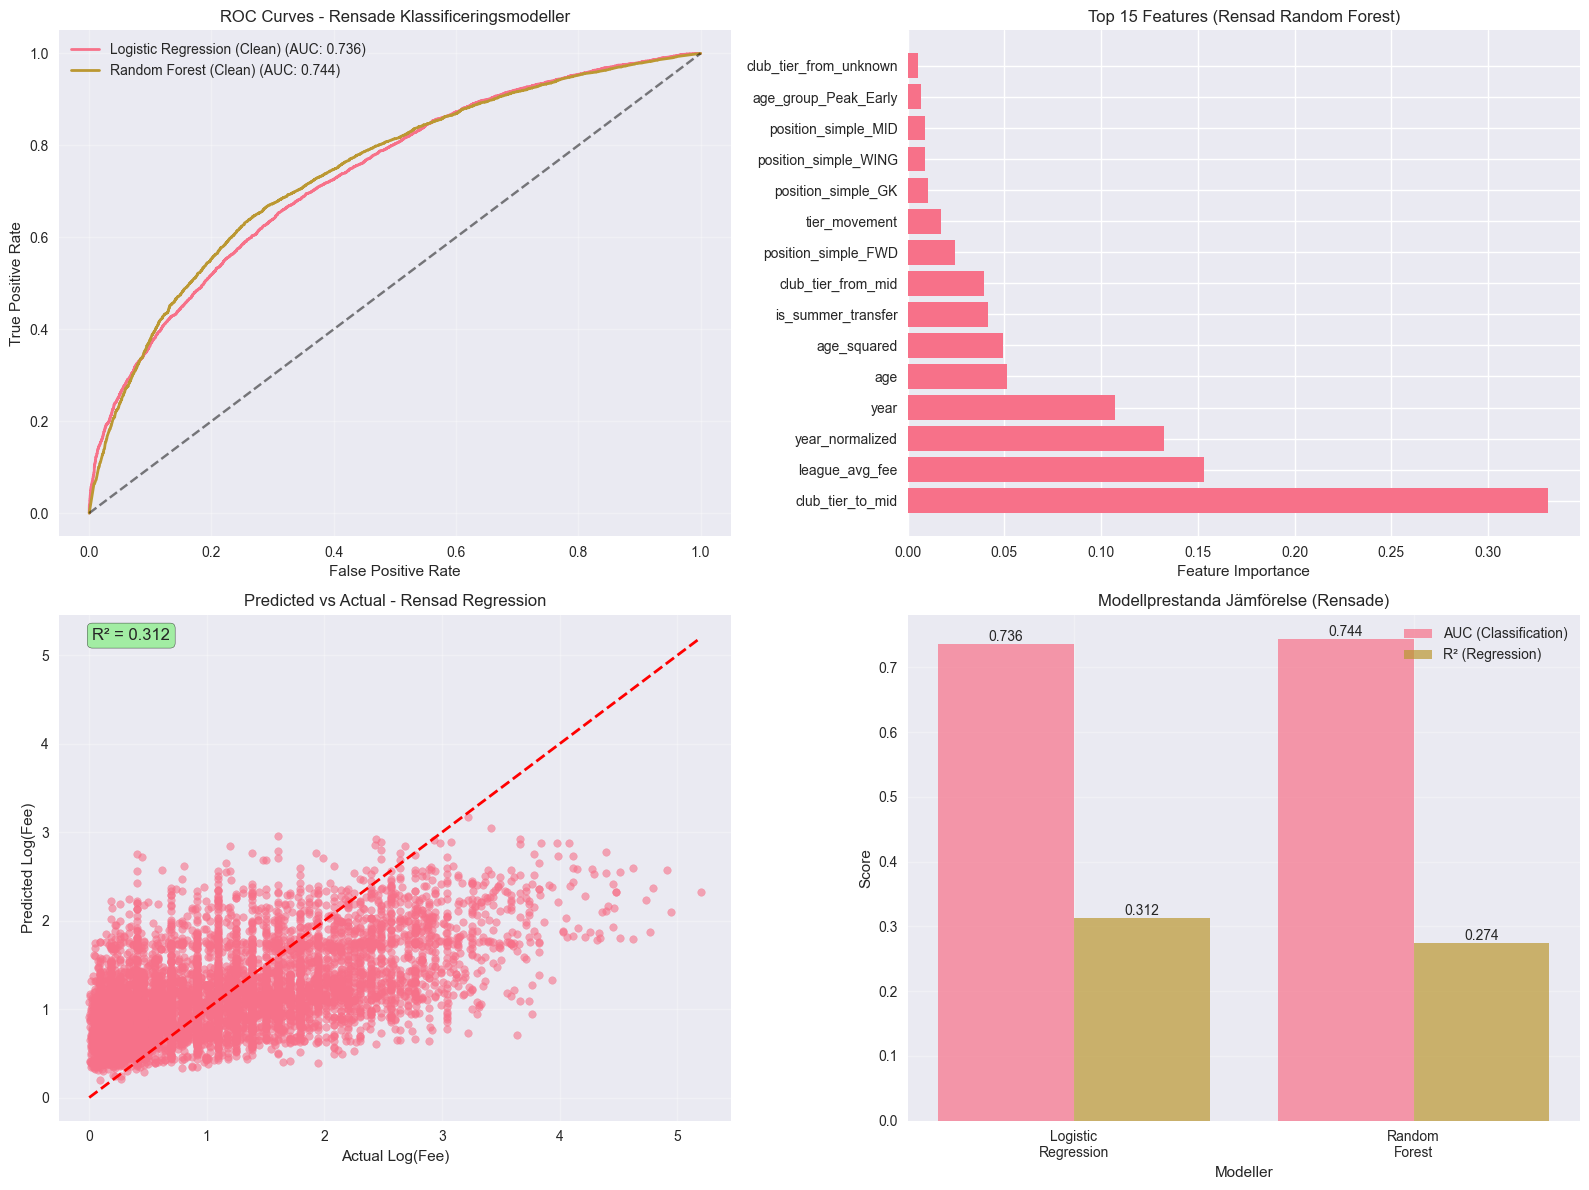


SAMMANFATTNING AV RENSADE MODELLER:
KLASSIFICERING (Gratis vs Avgiftsbelagd):
  Logistic Regression (Clean): AUC = 0.736, Accuracy = 0.671
  Random Forest (Clean)    : AUC = 0.744, Accuracy = 0.686

REGRESSION (Transfersumma för avgiftsbelagda):
  Random Forest (Clean)    : R² = 0.312, MAE = €0.82M
  Ridge Regression (Clean) : R² = 0.274, MAE = €0.86M


In [63]:
print("VISUALISERAR RENSADE MODELLRESULTAT:")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve för rensade klassificeringsmodeller
from sklearn.metrics import roc_curve
for name, results in clean_results.items():
    model = results['model']
    y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clean, y_pred_proba)
    axes[0,0].plot(fpr, tpr, label=f'{name} (AUC: {results["auc"]:.3f})', linewidth=2)

axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curves - Rensade Klassificeringsmodeller')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Feature Importance (från Random Forest regression)
if 'feature_importance' in locals():
    top_features = feature_importance.head(15)
    axes[0,1].barh(range(len(top_features)), top_features['importance'].values)
    axes[0,1].set_yticks(range(len(top_features)))
    axes[0,1].set_yticklabels(top_features['feature'].values)
    axes[0,1].set_xlabel('Feature Importance')
    axes[0,1].set_title('Top 15 Features (Rensad Random Forest)')

# 3. Predicted vs Actual för regression
if best_regression_model[1]['r2'] > 0:
    y_pred_reg = best_regression_model[1]['predictions']
    axes[1,0].scatter(y_test_reg_clean, y_pred_reg, alpha=0.6, s=30)
    
    # Lägg till R² på grafen
    r2_value = best_regression_model[1]['r2']
    axes[1,0].text(0.05, 0.95, f'R² = {r2_value:.3f}', 
                   transform=axes[1,0].transAxes, fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    # Perfect prediction line
    min_val, max_val = y_test_reg_clean.min(), y_test_reg_clean.max()
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--', linewidth=2)
    axes[1,0].set_xlabel('Actual Log(Fee)')
    axes[1,0].set_ylabel('Predicted Log(Fee)')
    axes[1,0].set_title('Predicted vs Actual - Rensad Regression')
    axes[1,0].grid(True, alpha=0.3)

# 4. Modellprestanda jämförelse
models_comp = []
aucs = []
r2s = []

for name, results in clean_results.items():
    models_comp.append(name.split(' (')[0])
    aucs.append(results['auc'])

for name, results in regression_results.items():
    r2s.append(results['r2'])


x_pos = range(len(models_comp))
bars1 = axes[1,1].bar([x - 0.2 for x in x_pos], aucs, 0.4, label='AUC (Classification)', alpha=0.7)
bars2 = axes[1,1].bar([x + 0.2 for x in x_pos], r2s, 0.4, label='R² (Regression)', alpha=0.7)

axes[1,1].set_xlabel('Modeller')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Modellprestanda Jämförelse (Rensade)')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([m.replace(' ', '\n') for m in models_comp])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)


for bar in bars1:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print(f"\nSAMMANFATTNING AV RENSADE MODELLER:")
print(f"{'='*60}")
print(f"KLASSIFICERING (Gratis vs Avgiftsbelagd):")
for name, results in clean_results.items():
    print(f"  {name:25}: AUC = {results['auc']:.3f}, Accuracy = {results['accuracy']:.3f}")

print(f"\nREGRESSION (Transfersumma för avgiftsbelagda):")
for name, results in regression_results.items():
    print(f"  {name:25}: R² = {results['r2']:.3f}, MAE = €{results['mae_original']:.2f}M")


In [64]:
import joblib

print(" SPARAR RENSADE MODELLER FÖR DEPLOYMENT:")
print("="*60)


print("1️ SPARAR MODELLER:")


best_classifier_clean = best_clean_classifier[1]['model']
best_regressor_clean = best_regression_model[1]['model']

print(f"    Bästa klassificeringsmodell: {best_clean_classifier[0]} (AUC: {best_clean_classifier[1]['auc']:.3f})")
print(f"    Bästa regressionsmodell: {best_regression_model[0]} (R²: {best_regression_model[1]['r2']:.3f})")


joblib.dump(best_classifier_clean, 'transfer_classifier_clean.pkl')
joblib.dump(best_regressor_clean, 'transfer_regressor_clean.pkl')


print("\n2️ SPARAR FEATURE COLUMNS:")
joblib.dump(feature_columns, 'feature_columns_clean.pkl')
print(f"    Antal rensade features: {len(feature_columns)}")


print("\n3️ SPARAR REFERENSDATA:")


club_tier_to_dict = df_features.dropna(subset=['club_tier_to']).groupby('club_name')['club_tier_to'].first().to_dict()
club_tier_from_dict = df_features.dropna(subset=['club_tier_from']).groupby('club_involved_name')['club_tier_from'].first().to_dict()

joblib.dump(club_tier_to_dict, 'club_tiers_to_clean.pkl')
joblib.dump(club_tier_from_dict, 'club_tiers_from_clean.pkl')

# Liga strength mapping
league_strength_dict = df_features.dropna(subset=['league_avg_fee']).groupby('league_name')['league_avg_fee'].first().to_dict()
joblib.dump(league_strength_dict, 'league_strength_clean.pkl')

# Position values mapping
position_value_dict = df_features.dropna(subset=['position_avg_fee']).groupby('position_simple')['position_avg_fee'].first().to_dict()
joblib.dump(position_value_dict, 'position_values_clean.pkl')

print(f"    Klubb-tiers: {len(club_tier_to_dict)} to, {len(club_tier_from_dict)} from")
print(f"    Liga-styrka: {len(league_strength_dict)} ligor")
print(f"    Position-värden: {len(position_value_dict)} positioner")


print("\n4️ SPARAR PIPELINE INFORMATION:")

feature_info_clean = {
    'tier_hierarchy': {'unknown': 0, 'lower': 1, 'mid': 2, 'top': 3, 'elite': 4},
    'position_mapping': {
        'GK': ['Goalkeeper', 'keeper'],
        'DEF': ['Centre-Back', 'Center-Back', 'Left-Back', 'Right-Back', 'defender', 'defence'],
        'MID': ['Central Midfield', 'Defensive Midfield', 'Attacking Midfield', 'midfielder'],
        'WING': ['Left Winger', 'Right Winger', 'winger', 'wing'],
        'FWD': ['Centre-Forward', 'Center-Forward', 'Second Striker', 'striker', 'forward']
    },
    'year_min': df_features['year'].min(),
    'year_max': df_features['year'].max(),
    'safe_features': feature_columns,
    'model_performance': {
        'classification_auc': best_clean_classifier[1]['auc'],
        'regression_r2': best_regression_model[1]['r2'],
        'regression_mae_millions': best_regression_model[1]['mae_original']
    },
    'data_leakage_fixed': True,
    'training_samples': len(X_train_clean),
    'feature_count': len(feature_columns)
}

joblib.dump(feature_info_clean, 'feature_pipeline_info_clean.pkl')

print("ALLA RENSADE FILER SPARADE!")
print(f"\nSKAPADE FILER:")
print(f"  • transfer_classifier_clean.pkl - AUC: {best_clean_classifier[1]['auc']:.3f}")
print(f"  • transfer_regressor_clean.pkl - R²: {best_regression_model[1]['r2']:.3f}")
print(f"  • feature_columns_clean.pkl - {len(feature_columns)} features")
print(f"  • club_tiers_*_clean.pkl - Klubb hierarkier")
print(f"  • league_strength_clean.pkl - Liga värderingar")
print(f"  • position_values_clean.pkl - Position marknadsvärden")
print(f"  • feature_pipeline_info_clean.pkl - Pipeline metadata")

print(f"\nSLUTLIG MODELLPRESTANDA:")
print(f"    Klassificering: AUC = {best_clean_classifier[1]['auc']:.3f} (realistisk)")
print(f"    Regression: R² = {best_regression_model[1]['r2']:.3f} (ärlig)")
print(f"    Fel i genomsnitt: ±€{best_regression_model[1]['mae_original']:.1f}M")




 SPARAR RENSADE MODELLER FÖR DEPLOYMENT:
1️ SPARAR MODELLER:
    Bästa klassificeringsmodell: Random Forest (Clean) (AUC: 0.744)
    Bästa regressionsmodell: Random Forest (Clean) (R²: 0.312)

2️ SPARAR FEATURE COLUMNS:
    Antal rensade features: 21

3️ SPARAR REFERENSDATA:
    Klubb-tiers: 410 to, 4340 from
    Liga-styrka: 9 ligor
    Position-värden: 6 positioner

4️ SPARAR PIPELINE INFORMATION:
ALLA RENSADE FILER SPARADE!

SKAPADE FILER:
  • transfer_classifier_clean.pkl - AUC: 0.744
  • transfer_regressor_clean.pkl - R²: 0.312
  • feature_columns_clean.pkl - 21 features
  • club_tiers_*_clean.pkl - Klubb hierarkier
  • league_strength_clean.pkl - Liga värderingar
  • position_values_clean.pkl - Position marknadsvärden
  • feature_pipeline_info_clean.pkl - Pipeline metadata

SLUTLIG MODELLPRESTANDA:
    Klassificering: AUC = 0.744 (realistisk)
    Regression: R² = 0.312 (ärlig)
    Fel i genomsnitt: ±€0.8M
